In [1]:
# Imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from einops import rearrange
from typing import List
import random
import os
import numpy as np

# Import your custom modules
from geniga.nn.diff import UNET, DDPM_Scheduler

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)


In [2]:
torch.cuda.is_available()

True

In [3]:
# Training function adapted for your geniga modules
def train(batch_size: int = 64,
          num_time_steps: int = 1000,
          num_epochs: int = 15,
          seed: int = -1,
          lr: float = 2e-5,
          checkpoint_path: str = None,
          save_path: str = 'checkpoints/ddpm_checkpoint.pth'):
    
    # Set seed
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)
    
    # Create checkpoints directory if it doesn't exist
    os.makedirs('checkpoints', exist_ok=True)
    
    # Load dataset (MNIST)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    
    # Initialize model and scheduler using your geniga classes
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET(
        input_channels=1,  # MNIST has 1 channel
        output_channels=1,  # Predicting noise with same channels
        time_steps=num_time_steps
    )
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    scheduler = scheduler.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Load checkpoint if provided
    start_epoch = 0
    if checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loaded checkpoint from epoch {start_epoch}")
    
    # Training loop
    model.train()
    for epoch in range(start_epoch, num_epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (x, _) in enumerate(progress_bar):
            x = x.to(device)
            
            # Pad images to 32x32 if needed
            if x.shape[-1] == 28:
                x = F.pad(x, (2, 2, 2, 2))
            
            # Sample random timesteps
            t = torch.randint(0, num_time_steps, (batch_size,), device=device)
            
            # Sample noise
            noise = torch.randn_like(x)
            
            # Add noise to images according to the diffusion process
            alpha_t = scheduler.alpha[t.cpu()].view(batch_size, 1, 1, 1).to(device)
            x_noisy = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise
            
            # Predict noise
            predicted_noise = model(x_noisy, t)
            
            # Compute loss
            loss = criterion(predicted_noise, noise)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1} | Average Loss: {avg_loss:.5f}')
        
        # Save checkpoint
        if (epoch + 1) % 5 == 0:  # Save every 5 epochs
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }
            torch.save(checkpoint, save_path)
            print(f"Checkpoint saved at epoch {epoch + 1}")
    
    # Save final model
    final_checkpoint = {
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }
    torch.save(final_checkpoint, save_path)
    print(f"Training completed. Final model saved to {save_path}")


In [13]:
# Helper function to display reverse diffusion process
def display_reverse(images: List, title: str = "Reverse Diffusion Process"):
    """Display a sequence of images showing the reverse diffusion process"""
    if not images:
        return
    
    fig, axes = plt.subplots(1, len(images), figsize=(2*len(images), 2))
    if len(images) == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        if i < len(images):
            img = images[i].squeeze(0) if images[i].dim() == 4 else images[i]
            img = img.squeeze(0) if img.dim() == 3 and img.shape[0] == 1 else img
            
            # Convert to numpy and handle normalization
            img_np = img.detach().cpu().numpy()
            img_np = (img_np + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
            img_np = np.clip(img_np, 0, 1)
            
            ax.imshow(img_np, cmap='gray')
            ax.set_title(f'Step {i}')
        ax.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Inference function adapted for your geniga modules
def inference(checkpoint_path: str = 'checkpoints/ddpm_checkpoint.pth',
              num_time_steps: int = 1000,
              num_samples: int = 1,
              show_process: bool = True,
              save_images: bool = False):
    """
    Generate new images using the trained diffusion model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps).to(device)
    model = UNET(
        input_channels=1,
        output_channels=1,
        time_steps=num_time_steps
    ).to(device)
    
    # Load checkpoint
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found at {checkpoint_path}")
        return
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Loaded model from epoch {checkpoint['epoch']}")
    
    # Generate samples
    with torch.no_grad():
        for sample_idx in range(num_samples):
            print(f"Generating sample {sample_idx + 1}/{num_samples}")
            
            # Start with pure noise
            z = torch.randn(1, 1, 32, 32, device=device)
            
            # Store intermediate images for visualization
            if show_process:
                process_images = []
                # Save specific timesteps to show the process
                save_steps = [999, 800, 600, 400, 200, 100, 50, 20, 10, 0]
            
            # Reverse diffusion process
            for t in tqdm(reversed(range(num_time_steps)), desc="Denoising"):
                t_tensor = torch.tensor([t], device=device)
                
                # Predict noise
                predicted_noise = model(z, t_tensor)
                
                # Compute denoising step
                beta_t = scheduler.beta[t].to(device)
                alpha_t = scheduler.alpha[t].to(device)
                
                # Remove predicted noise
                if t > 0:
                    # Compute the mean of the reverse process
                    coef1 = 1 / torch.sqrt(1 - beta_t)
                    coef2 = beta_t / torch.sqrt(1 - alpha_t)
                    z = coef1 * (z - coef2 * predicted_noise)
                    
                    # Add noise for stability (except at the last step)
                    noise = torch.randn_like(z)
                    z = z + torch.sqrt(beta_t) * noise
                else:
                    # Final step - no noise added
                    coef1 = 1 / torch.sqrt(1 - beta_t)
                    coef2 = beta_t / torch.sqrt(1 - alpha_t)
                    z = coef1 * (z - coef2 * predicted_noise)
                
                # Save intermediate results
                if show_process and t in save_steps:
                    process_images.append(z.clone())
            
            # Final generated image
            generated_image = z
            
            # Display results
            plt.figure(figsize=(6, 6))
            img = generated_image.squeeze(0).squeeze(0).cpu().numpy()
            img = (img + 1) / 2  # Denormalize
            img = np.clip(img, 0, 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Generated Sample {sample_idx + 1}')
            plt.axis('off')
            plt.show()
            
            # Show the reverse process
            if show_process and process_images:
                display_reverse(process_images, f"Sample {sample_idx + 1} - Reverse Process")
            
            # Save image if requested
            if save_images:
                os.makedirs('generated_images', exist_ok=True)
                plt.figure(figsize=(6, 6))
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.savefig(f'generated_images/sample_{sample_idx + 1}.png', bbox_inches='tight')
                plt.close()
    
    print("Inference completed!")


/tmp/ipykernel_145585/3446621201.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from epoch 5
Generating sample 1/1


Denoising: 1000it [00:02, 391.34it/s]


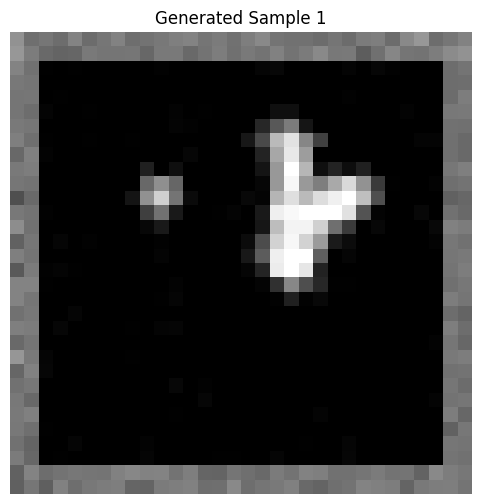

In [ ]:
#train(checkpoint_path='checkpoints/ddpm_checkpoint', lr=2e-5, num_epochs=75)
inference('checkpoints/ddpm_checkpoint.pth')